In [1]:
import os
import sys
sys.path.append('..')
import json
import torch
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader
from libs.helper import calculate_confusion_matrix, calculate_eer_threshold
from libs.dataloader import SeNSEDataset
from libs.model import ECG_Inception, PPG_Inception, EDA_LSTM

In [2]:
subject_id = "c2s01"
data_dir = "../data"
out_dir = "../results"
data_type = "eda"

In [3]:
data_path = f'{data_dir}/{subject_id}/{data_type}.pkl'
metadata_path = f'{data_dir}/{subject_id}/metadata.json'
data = pd.read_pickle(data_path)
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

In [4]:
versions = list(metadata.keys())

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = {}
for version in versions:
    print(f'Version: {version}')
    out_ver_dir = os.path.join(out_dir, data_type, subject_id, version)
    ckpt_path = os.path.join(out_ver_dir, "best.pth")
    if not os.path.exists(ckpt_path):
        print(f"Checkpoint not found for {version}")
        continue

    train_data = SeNSEDataset(data, metadata[version]['train'], data_type=data_type, verbose=False)
    val_data = SeNSEDataset(data, metadata[version]['val'], data_type=data_type, verbose=False)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

    if data_type == 'ecg':
        model = ECG_Inception(normal_hypo_ratio=train_data.normal_hypo_ratio)
    elif data_type == 'ppg':
        model = PPG_Inception(normal_hypo_ratio=train_data.normal_hypo_ratio)
    elif data_type == 'eda':
        model = EDA_LSTM(normal_hypo_ratio=train_data.normal_hypo_ratio)
    else:
        raise ValueError(f"Unknown data type: {data_type}")
    
    model.load_state_dict(torch.load(ckpt_path))
    model.to(device)
    model.eval()

    train_results = None
    val_results = None
    with torch.no_grad():
        for idx, loader in enumerate([train_loader, val_loader]):
            preds = []
            labels = []
            for i, (signal_data, hypo_label, glucose, cgm_idx) in enumerate(loader):
                if data_type == 'eda':
                    phasic, tonic = signal_data
                    phasic, tonic, hypo_label, glucose = phasic.float().to(device), tonic.float().to(device), hypo_label.float().to(device), glucose.float().to(device)
                    pred_label = model(phasic, tonic)
                    num_data = phasic.shape[0]

                    if phasic.shape[0] == 1:
                        pred_label = pred_label.unsqueeze(0)
                else:
                    signal_data, hypo_label, glucose = signal_data.float().to(device), hypo_label.float().to(device), glucose.float().to(device)
                    pred_label = model(signal_data)
                    num_data = signal_data.shape[0]

                    if signal_data.shape[0] == 1:
                        pred_label = pred_label.unsqueeze(0)
                preds += list(pred_label.cpu().numpy())
                labels += list(hypo_label.cpu().numpy())

            if idx == 0:
                train_results = pd.DataFrame({'pred': preds, 'label': labels})
            else:
                val_results = pd.DataFrame({'pred': preds, 'label': labels})

    results[version] = {'train': train_results, 'val': val_results}

Version: v1
Version: v2
Version: v3
Version: v4
Version: v5


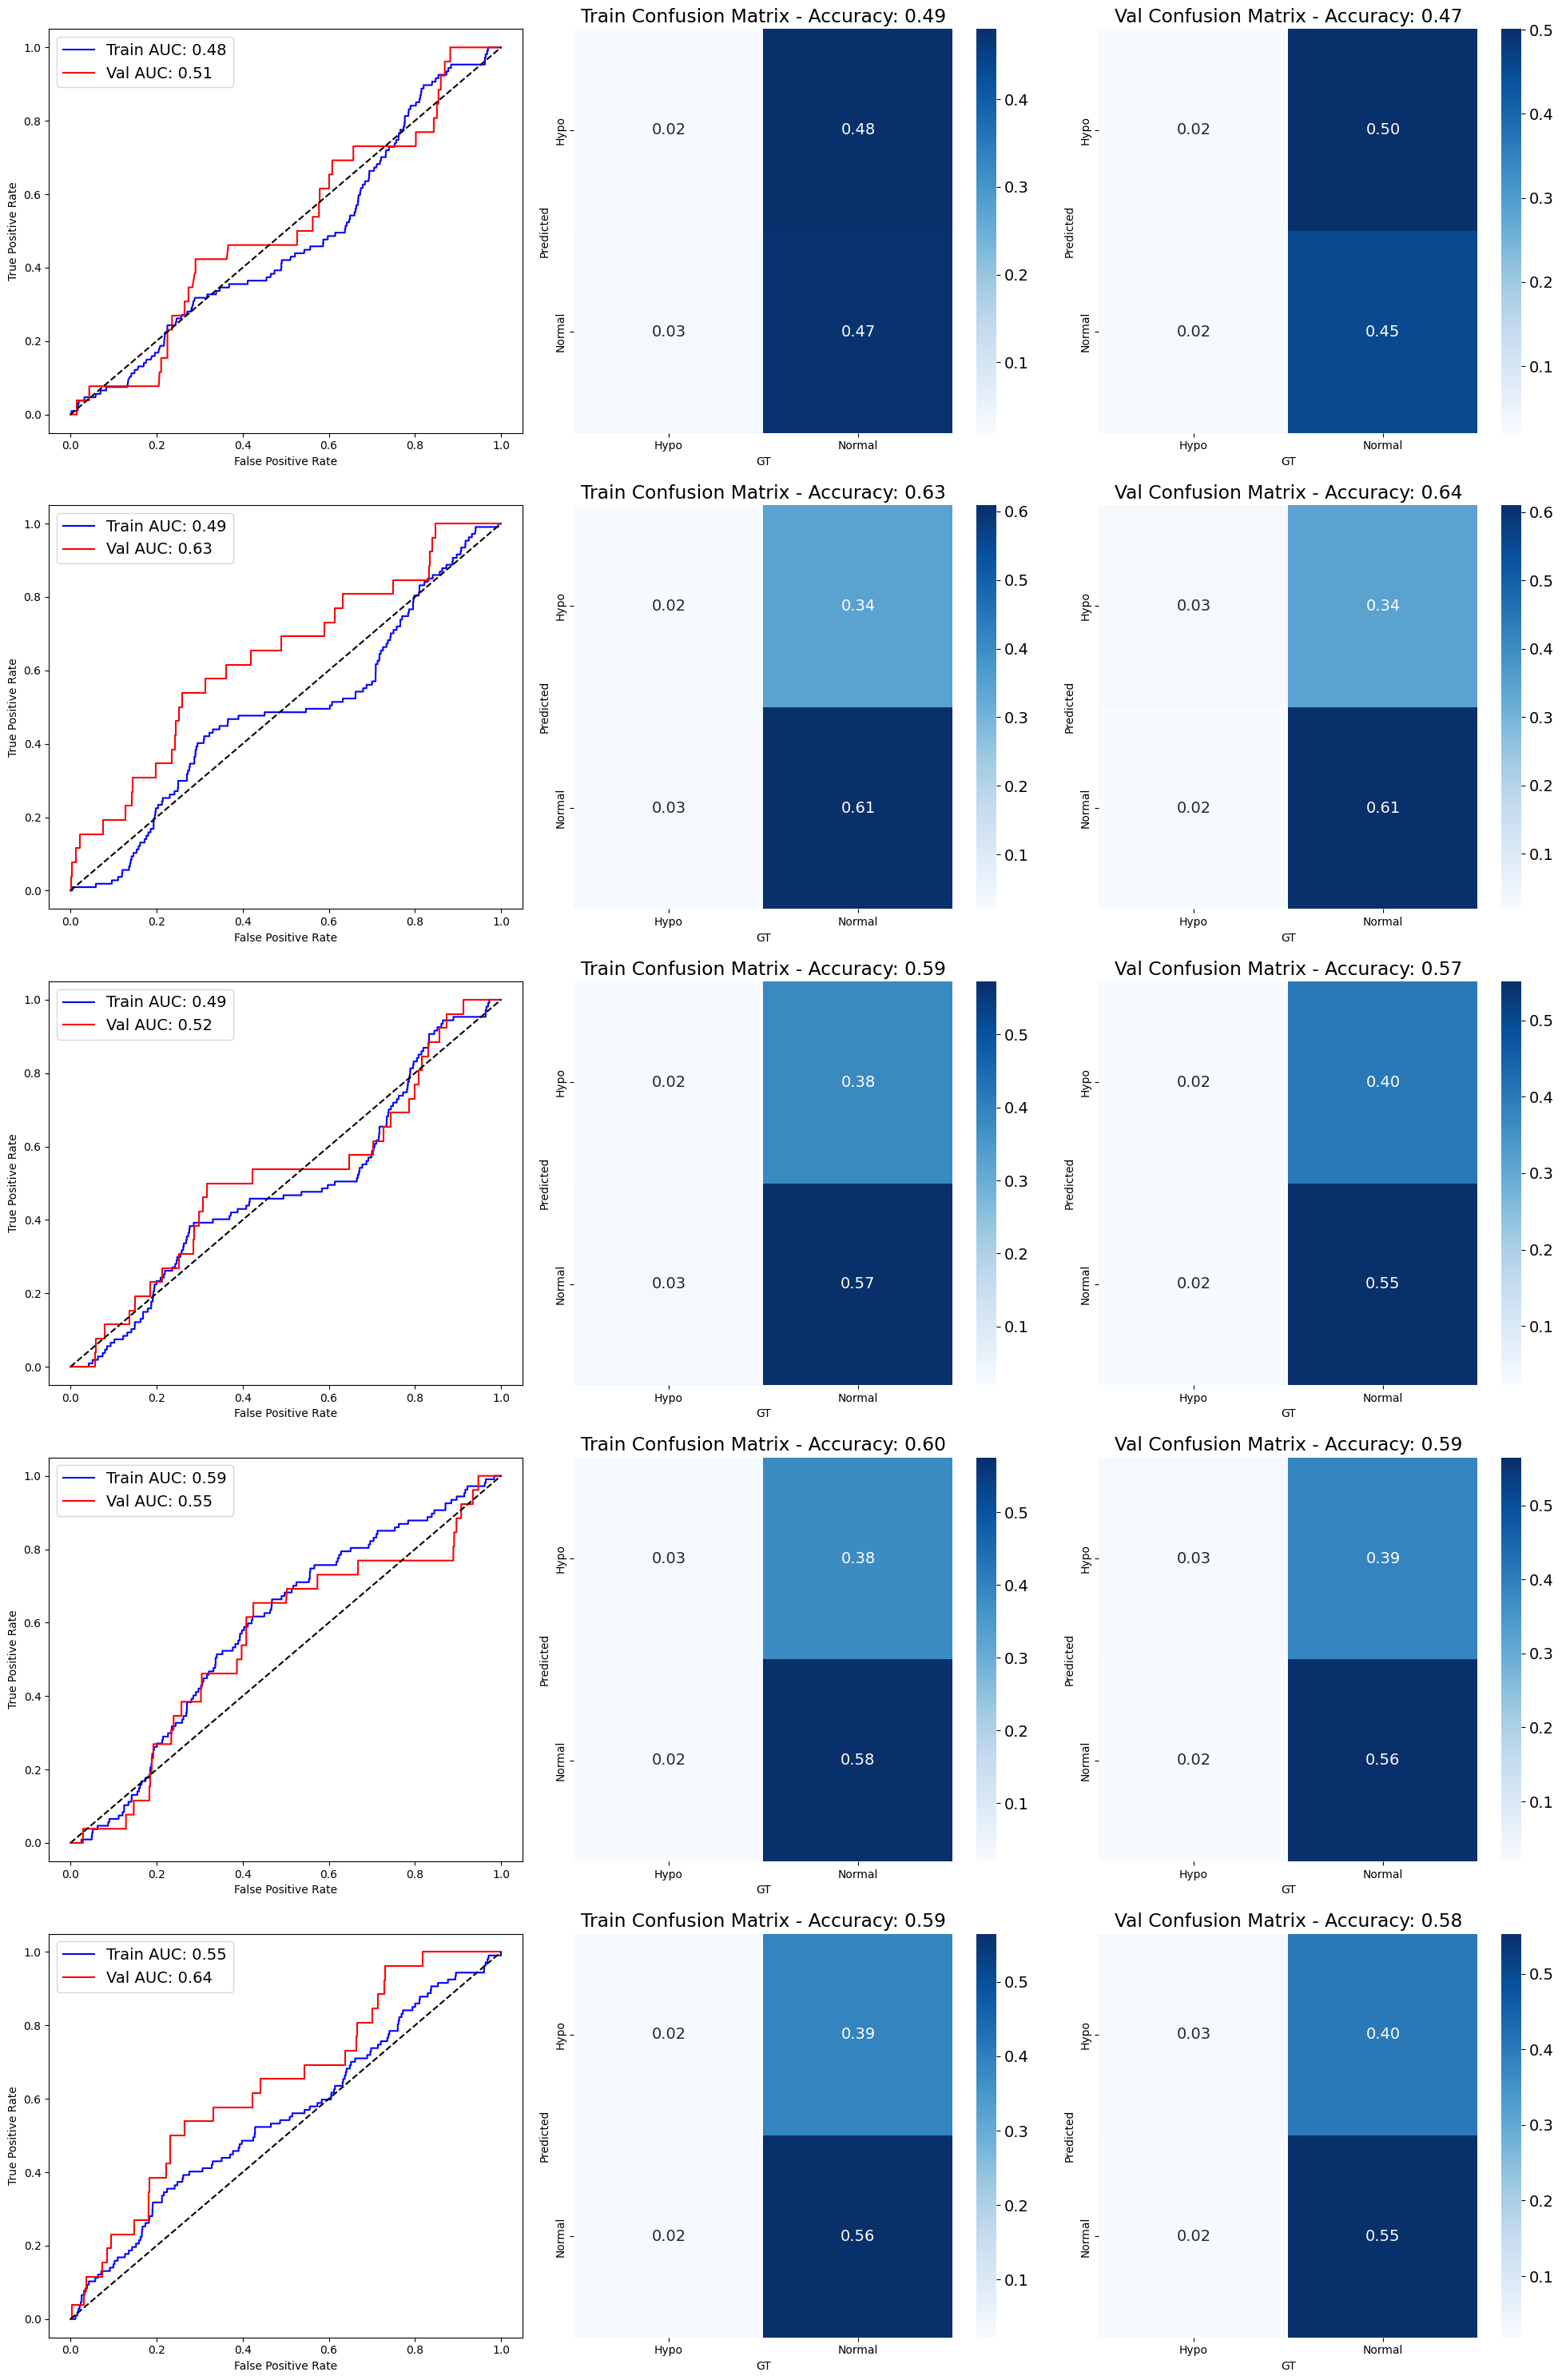

In [6]:
fig, ax = plt.subplots(5, 3, figsize=(20, 30))
accs = defaultdict(list)
specificities = defaultdict(list)
sensitivities = defaultdict(list)
for i, key in enumerate(results):
    # set the font size of the figure
    plt.rcParams.update({'font.size': 14, 'axes.labelsize': 14})

    train_pred = results[key]['train']['pred']
    train_label = results[key]['train']['label']
    train_fpr, train_tpr, _ = roc_curve(train_label, train_pred)
    train_auc = auc(train_fpr, train_tpr)

    val_pred = results[key]['val']['pred']
    val_label = results[key]['val']['label']
    val_fpr, val_tpr, _ = roc_curve(val_label, val_pred) 
    val_auc = auc(val_fpr, val_tpr)


    eer_threshold = calculate_eer_threshold(val_pred, val_label)
    train_confusion_matrix, train_sensitivity, train_specificity = calculate_confusion_matrix(train_pred, train_label, eer_threshold)
    val_confusion_matrix, val_sensitivity, val_specificity = calculate_confusion_matrix(val_pred, val_label, eer_threshold)

    ax[i,0].plot(train_fpr, train_tpr, label=f'Train AUC: {train_auc:.2f}', color='b')
    ax[i,0].plot(val_fpr, val_tpr, label=f'Val AUC: {val_auc:.2f}', color='r')
    ax[i,0].plot([0, 1], [0, 1], 'k--')
    ax[i,0].set_xlabel('False Positive Rate')
    ax[i,0].set_ylabel('True Positive Rate')
    ax[i,0].legend()

    sns.heatmap(train_confusion_matrix, annot=True, fmt=".2f", cmap='Blues', ax=ax[i,1])
    ax[i,1].set_xticklabels(['Hypo', 'Normal'])
    ax[i,1].set_yticklabels(['Hypo', 'Normal'])
    ax[i,1].set_xlabel('GT')
    ax[i,1].set_ylabel('Predicted')
    ax[i,1].set_title('Train Confusion Matrix - Accuracy: {:.2f}'.format(train_confusion_matrix[0, 0] + train_confusion_matrix[1, 1]))
    
    sns.heatmap(val_confusion_matrix, annot=True, fmt=".2f", cmap='Blues', ax=ax[i,2])
    ax[i,2].set_xticklabels(['Hypo', 'Normal'])
    ax[i,2].set_yticklabels(['Hypo', 'Normal'])
    ax[i,2].set_xlabel('GT')
    ax[i,2].set_ylabel('Predicted')
    ax[i,2].set_title('Val Confusion Matrix - Accuracy: {:.2f}'.format(val_confusion_matrix[0, 0] + val_confusion_matrix[1, 1]))

    accs['train'].append(train_confusion_matrix[0, 0] + train_confusion_matrix[1, 1])
    accs['val'].append(val_confusion_matrix[0, 0] + val_confusion_matrix[1, 1])

    specificities['train'].append(train_specificity)
    specificities['val'].append(val_specificity)

    sensitivities['train'].append(train_sensitivity)
    sensitivities['val'].append(val_sensitivity)
    
plt.tight_layout()
plt.savefig(f'{out_dir}/{data_type}/{subject_id}/roc.png')
plt.show()
plt.close()


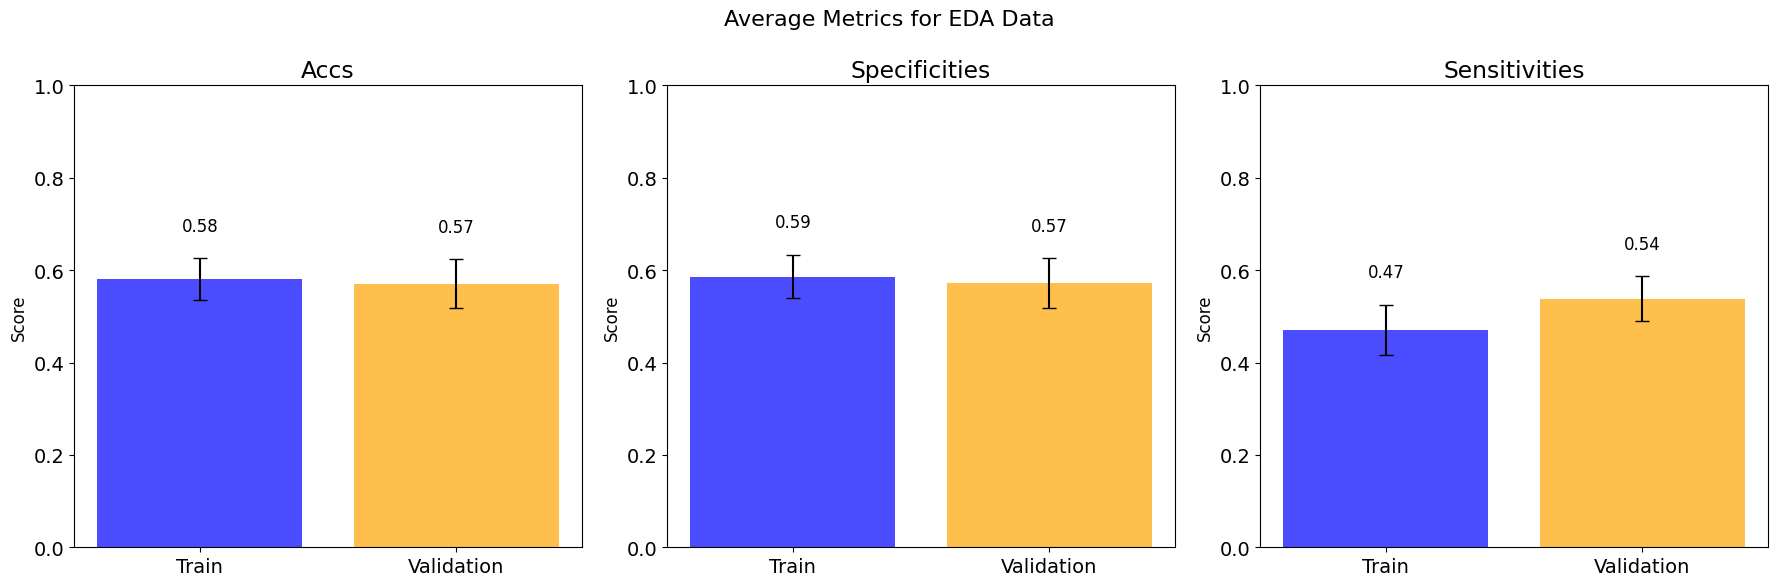

In [8]:
# # Calculate means and standard deviations for each metric
metrics = ['accs', 'specificities', 'sensitivities']
results_data = {
    "accs": {
        "train": accs['train'],
        "val": accs['val']
    },
    "specificities": {
        "train": specificities['train'],
        "val": specificities['val']
    },
    "sensitivities": {
        "train": sensitivities['train'],
        "val": sensitivities['val']
    }
}
averages = {metric: {
    "train_mean": np.mean(results_data[metric]["train"]),
    "train_std": np.std(results_data[metric]["train"]),
    "val_mean": np.mean(results_data[metric]["val"]),
    "val_std": np.std(results_data[metric]["val"])
} for metric in metrics}

# Plot the averaged results with error bars
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot each metric
for i, metric in enumerate(metrics):
    train_mean = averages[metric]["train_mean"]
    train_std = averages[metric]["train_std"]
    val_mean = averages[metric]["val_mean"]
    val_std = averages[metric]["val_std"]

    axs[i].bar(
        ["Train", "Validation"],
        [train_mean, val_mean],
        yerr=[train_std, val_std],
        capsize=5,
        color=["blue", "orange"],
        alpha=0.7
    )

    # plot the values on top of the bars
    for j, (value, std) in enumerate(zip([train_mean, val_mean], [train_std, val_std])):
        axs[i].text(
            j,
            value + abs(std) + 0.05,
            f"{value:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=12
        )
    
    axs[i].set_title(f"{metric.capitalize()}")
    axs[i].set_ylabel("Score", fontsize=12)
    axs[i].set_ylim(0, 1)  # Scores are between 0 and 1

# Adjust layout
plt.suptitle(f"Average Metrics for {data_type.upper()} Data", fontsize=16)
plt.tight_layout()
plt.savefig(f'{out_dir}/{data_type}/{subject_id}/results.png')
plt.show()
